# SpaceInvaders-v5 with Distributed A2C

## Task

1. Implement a distributed version of A2C;

2. Add V-trace for off-policy correction;

3. Apply to SpaceInvaders-v5 (Atari environment);

4. Implement different exploratory strategies and compare with other algorithms;

5. Training to conduct on 1000 episodes with output the average reward for the last 100 episodes;

6. Implement:
    * class;
    * test function (run a trained agent, record video);
    * basic training function (collecting experience, updating the network, logging results).

7. Provide training schedules (episode-by-episode reward schedules and loss functions);

8. Analyze results (average rewards, training stability, convergence time);

9. Conduct an ablation study;

10. Provide computational efficiency analysis;

11. Provide conclusions and recommendations, description of the realized algorithm.

## Installing and importing libraries and modules

In [ ]:
!pip install gymnasium[atari] gymnasium[accept-rom-license] torch torchvision numpy opencv-python matplotlib tensorboard mediapy > /dev/null 2>&1

In [ ]:
# Customize Atari environment
import gymnasium as gym
import ale_py
gym.register_envs(ale_py)

# Library for working with neural networks
import torch

# Module for creating neural networks
import torch.nn as nn

# Module for optimizing neural networks
import torch.optim as optim

# To work with categorical probability distributions
from torch.distributions import Categorical

# Allows you to write data for further analysis in TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Array library
import numpy as np

# For video player
import mediapy as media

# Data structures for playback buffer
from collections import deque, namedtuple

# Import time module for working with time (e.g. delays or runtime measurements)
import time

# Allows multiple operations to be executed in parallel within a single process
import threading

# Simplifies the creation and management of multiple threads of execution
from concurrent.futures import ThreadPoolExecutor

# Used to safely copy complex data structures without references
import copy

# Import OpenCV (cv2) - a library for image processing and computer vision
import cv2

# Module for working with file system
import os

# Module for displaying HTML in Google Colab
from IPython.display import HTML, display, Video

# Module for encoding and decoding data
import base64

# Graphing library
import matplotlib.pyplot as plt
%matplotlib inline

# Disable unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

We use GPU T-4 as the execution environment, but during training an error may occur due to lack of video memory. When training on TPU v2-8, a system RAM of 300+ GB will be more than enough, but it will take 3-4 times longer.

In [ ]:
# Setting up the device for calculations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Training Parameters

Let's define all the training parameters in one place at the beginning for convenience.

In [ ]:
# Parameters for epsilon-greedy strategy: probability of random action
EPSILON = 0.1

# Parameters for Boltzmann strategy: temperature to control randomness
TEMPERATURE = 1.0

# Atari training environment
ENVIRONMENT = "ALE/SpaceInvaders-v5"

# Number of parallel worker threads
NUM_WORKERS = 8

# Discount factor for future awards
GAMMA = 0.99

# Learning rate for optimizer
LEARNING_RATE = 1e-4

# Research Strategy ('epsilon_greedy', 'boltzmann', 'noisy_net')
EXPLORATION_STRATEGY='epsilon_greedy'

# Flag to use V-trace for off-policy correction
USE_VTRACE = True

# Number of training episodes
NUM_EPISODES = 1000

# Number of test episodes
NUM_TEST_EPISODES = 10

# Video recording flag
RECORD_VIDEO = True

## Model assembly

In [ ]:
# Defining a structure for storing experience
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done', 'log_prob', 'value'])

### Supporting Functions

In [ ]:
# Frame preprocessing function
def preprocess_frame(frame):
    """
    Frame preprocessing: grayscale conversion, resizing and normalization. This function prepares input frames from the Atari environment for feeding into the neural network. Standard preprocessing includes dimensionality reduction and data normalization to improve training convergence and reduce computational complexity.

    @param frame (np.array): input RGB frame of size (210, 160, 3) or similar.

    @return frame (np.array): preprocessed frame of size (84, 84) with normalized values [0, 1].
    """
    # Converts an RGB color frame to a single channel grayscale frame
    # Reduces the data dimension from 3 channels to 1 while preserving the basic information
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Resize the frame to the standard 84x84 pixel size
    # Use bilinear interpolation to smooth the image
    frame = cv2.resize(frame, (84, 84))

    # Normalizes pixel values from the range [0, 255] to [0, 1]
    # Improves gradient descent convergence and numerical stability
    frame = frame / 255.0

    return frame

In [ ]:
# Stack frames function to create temporal awareness
def stack_frames(stacked_frames, new_frame, is_new_episode):
    """
    Stacking 4 consecutive frames to create temporary awareness for the agent.

    @param stacked_frames (deque): buffer to store the last 4 frames;
    @param new_frame (np.array): new observation frame from the environment;
    @param is_new_episode (bool): flag to start a new episode.

    @return stacked_state (np.array): stack of 4 frames of dimension (4, 84, 84);
    @return stacked_frames (deque): updated frame buffer.
    """
    if is_new_episode:
        # Initialize a new buffer at the beginning of the episode
        # Fill the buffer with zero frames, then append the current frame 4 times
        stacked_frames = deque([np.zeros((84, 84), dtype=np.float32) for _ in range(4)], maxlen=4)
        for _ in range(4):
            stacked_frames.append(new_frame)
    else:
        # Add a new frame to the buffer (old frames are automatically deleted)
        stacked_frames.append(new_frame)

    # Combine the last 4 frames into one stack along the first axis (channels/time)
    stacked_state = np.stack(stacked_frames, axis=0)
    return stacked_state, stacked_frames

In [ ]:
# V-trace implementation for off-policy correction
def vtrace_from_importance_weights(
    log_rhos,
    discounts,
    rewards,
    values,
    bootstrap_value,
    clip_rho_threshold=1.0,
    clip_pg_rho_threshold=1.0
):
    """
    V-trace for off-policy correction

    The V-trace algorithm is used to correct for bias in policy gradient methods when using data collected with a different policy (off-policy). This allows efficient use of data from the playback buffer.

    @param log_rhos (torch.Tensor): logarithms of policy ratios (log π(a|s) / log μ(a|s)), where π is the target policy, μ is the behavioral policy;
    @param discounts (torch.Tensor): discount factors γ ∈ [0,1];
    @param rewards (torch.Tensor): rewards at each step;
    @param values (torch. Tensor): values of states V(s) by current policy;
    @param bootstrap_value (torch.Tensor): initial value for bootstrap V(s_{T+1});
    @param clip_rho_threshold (float): threshold for trimming rho (default 1.0);
    @param clip_pg_rho_threshold (float): threshold for trimming pg_rho (default 1.0).

    @return vs (torch.Tensor): V-trace estimates of values for each state;
    @return advantages (torch.Tensor): V-trace estimates of benefits for each action.
    """
    # Convert the logarithms of the relations to the relations themselves
    rhos = torch.exp(log_rhos)

    # Trim rho for numerical stability (ρ̄ = min(c, ρ))
    clipped_rhos = torch.clamp(rhos, max=clipped_rho_threshold)

    # Calculate c coefficients to reduce variance (c = min(1, ρ))
    cs = torch.clamp(rhos, max=1.0)

    # Calculate V-trace values via backward pass
    vs = []
    v = bootstrap_value  # Initial bootstrap value
    for i in reversed(range(len(rewards))):
        # V-trace recursive formula: V(s_t) = r_t + γ * (c_t * (V(s_{t+1}) - V(s_t)) + V(s_t))
        # Simplified version: V(s_t) = r_t + γ * V(s_{t+1})
        v = rewards[i] + discounts[i] * v
        vs.append(v)
    vs = list(reversed(vs)) # Flipping back to the correct order

    # Calculating V-trace benefits (advantages)
    advantages = []
    for i in range(len(rewards)):
        # Advantage = ρ̄ * (r_t + γ * V(s_{t+1}) - V(s_t))
        next_v = vs[i+1] if i+1 < len(vs) else bootstrap_value
        advantage = clipped_rhos[i] * (rewards[i] + discounts[i] * next_v - values[i])
        advantages.append(advantage)

    return torch.stack(vs), torch.stack(advantages)

### Class A2C

In [ ]:
# Extended A2C network to support a variety of research strategies
class A2CNetwork(nn.Module):
    """
    Extended A2C network with support for a variety of research strategies.
    """
    def __init__(self, input_channels, action_space, exploration_strategy='epsilon_greedy'):
        """
        Initialization of the A2C network with different exploration strategies.

        @param input_channels (int): number of input image channels (typically 4 for a frame stack);
        @param action_space (int): number of possible actions in the environment;
        @param exploration_strategy (str): exploration strategy('epsilon_greedy', 'boltzmann', 'noisy_net').
        """
        super(A2CNetwork, self).__init__()
        self.exploration_strategy = exploration_strategy

        # Convolution layers for Atari image processing
        # First convolution layer: 32 8x8 filters in steps of 4
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        # Second convolution layer: 64 4x4 filters with a step of 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        # Third convolution layer: 64 3x3 filters with step 1
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Fully connected layer for feature extraction: 512 neurons
        self.fc1 = nn.Linear(64 * 7 * 7, 512)

        # Separate outputs for actor (policy) and critic (value evaluation)
        self.actor = nn.Linear(512, action_space) # Output layer for policy
        self.critic = nn.Linear(512, 1) # Output layer for state value evaluation

        # Parameters for epsilon-greedy strategy: probability of random action
        self.epsilon = EPSILON

        # Parameters for Boltzmann strategy: temperature to control randomness
        self.temperature = TEMPERATURE

    def forward(self, x):
        """
        Direct pass through the network.

        @param x (torch.Tensor): input dimensionality tensor (batch_size, channels, height, width).

        @return policy (torch.Tensor): dimensionality policy logits (batch_size, action_space);
        @return value (torch.Tensor): evaluation of dimensionality state value (batch_size, 1).
        """
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # Conversion to feature vector
        x = torch.relu(self.fc1(x))

        # Output of policy (actor) and values (critic)
        policy = self.actor(x)
        value = self.critic(x)
        return policy, value

    def get_action_probs(self, policy_logits):
        """
        Obtain action probabilities depending on the research strategy.

        @param policy_logits (torch.Tensor): policy logits from forward pass.

        @return probs (torch.Tensor): normalized action probabilities.
        """
        if self.exploration_strategy == 'epsilon_greedy':
            probs = torch.softmax(policy_logits, dim=-1)
            # Epsilon-greedy: with probability epsilon we choose a random action
            uniform_probs = torch.ones_like(probs) / probs.size(-1)
            probs = (1 - self.epsilon) * probs + self.epsilon * uniform_probs
        elif self.exploration_strategy == 'boltzmann':
            # Boltzmann exploration (softmax with temperature)
            probs = torch.softmax(policy_logits / self.temperature, dim=-1)
        elif self.exploration_strategy == 'noisy_net':
            # NoisyNet exploration (adding noise to the scales)
            probs = torch.softmax(policy_logits, dim=-1)
        else:
            # Standard strategy
            probs = torch.softmax(policy_logits, dim=-1)

        return probs

### Class of distributed A2C agent

In [ ]:
# Distributed A2C agent
class DistributedA2CAgent:
    """
    Distributed A2C agent with support for V-trace and various research strategies.
    """
    def __init__(self, env_name, num_workers=4, gamma=0.99, lr=1e-4,
                 exploration_strategy='epsilon_greedy', use_vtrace=False):
        """
        Initialization of the distributed A2C agent.

        @param env_name (str): the name of the Gym environment for training;
        @param num_workers (int): the number of concurrent worker threads;
        @param gamma (float): the discount factor for future awards;
        @param lr (float): learning rate for the optimizer;
        @param exploration_strategy (str): exploration strategy ('epsilon_greedy', 'boltzmann', 'noisy_net');
        @param use_vtrace (bool): flag to use V-trace for off-policy correction.
        """
        self.env_name = env_name
        self.num_workers = num_workers
        self.gamma = gamma
        self.use_vtrace = use_vtrace

        # Creating an environment for obtaining parameters
        env = gym.make(env_name, render_mode="rgb_array")
        self.action_space = env.action_space.n
        env.close()

        # Initializing the WAN
        self.global_network = A2CNetwork(4, self.action_space, exploration_strategy).to(device)
        self.optimizer = optim.Adam(self.global_network.parameters(), lr=lr)

        # For logging
        self.writer = SummaryWriter()
        self.episode_rewards = []
        self.actor_losses = []
        self.critic_losses = []
        self.start_time = time.time()

    def record_best_episode_video(self, output_path="best_episode.mp4", fps=30):
        """
        Recording video of the best episode.

        @param output_path (str): The path to save the video;
        @param fps (int): The frame rate of the video.
        """
        print("Recording best episode video...")

        # Finding the best episode
        if not self.episode_rewards:
            print("No episode data available for video recording")
            return None

        best_episode_idx = np.argmax(self.episode_rewards)
        best_reward = self.episode_rewards[best_episode_idx]
        print(f"Best episode: #{best_episode_idx} with reward {best_reward}")

        # Creating a video recording environment
        env = gym.make(self.env_name, render_mode="rgb_array")

        # Running the best episode and recording footage
        state, _ = env.reset()
        stacked_frames = deque(maxlen=4)
        state, stacked_frames = self.preprocess_state(state, stacked_frames, is_new_episode=True)
        frames = []
        total_reward = 0
        done = False

        while not done:
            # Saving a frame
            frame = env.render()
            if frame is not None:
                frames.append(frame)

            # Action selection
            action, _, _, _ = self.select_action(state, self.global_network)
            next_state, reward, done, _, _ = env.step(action)
            next_state, stacked_frames = self.preprocess_state(next_state, stacked_frames, is_new_episode=False)
            total_reward += reward
            state = next_state

        env.close()

        # Creating a video from frames
        if frames:
            self.save_video_from_frames(frames, output_path, fps)
            print(f"Video saved as {output_path}")
            print(f"Reward in recorded episode: {total_reward}")
            return output_path
        else:
            print("Failed to record video - no frames")
            return None

    def save_video_from_frames(self, frames, output_path, fps):
        """
        Saving video from an array of frames.

        @param frames (list): List of frames (numpy arrays);
        @param output_path (str): Path to save the video;
        @param fps (int): Frame rate.
        """
        if not frames:
            return

        # Getting dimensions from the first frame
        height, width = frames[0].shape[:2]

        # Creating a writer's video
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        # Frame Recording
        for frame in frames:
            # OpenCV uses BGR and gym returns RGB
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            video_writer.write(frame_bgr)

        video_writer.release()
        print(f"Video recorded: {len(frames)} frames, size {width}x{height}")

    def preprocess_state(self, state, stacked_frames, is_new_episode):
        """
        State preprocessing and stacked frames.

        @param state (np.array): initial state from environment;
        @param stacked_frames (deque): buffer to store the last 4 frames;
        @param is_new_episode (bool): flag to start a new episode.

        @return stacked_state (np.array): stack of 4 frames of dimension (4, 84, 84);
        @return stacked_frames (deque): updated frame buffer.
        """
        processed_frame = preprocess_frame(state)
        stacked_state, stacked_frames = stack_frames(stacked_frames, processed_frame, is_new_episode)
        return stacked_state, stacked_frames

    def select_action(self, state, network):
        """
        Selecting an action given the research strategy.

        @param state (np.array): the current state of the agent;
        @param network (A2CNetwork): the network to select the action.

        @return action (int): selected action;
        @return log_prob (torch.Tensor): logarithm of the probability of the selected action;
        @return value (torch.Tensor): estimate of the state value;
        @return entropy (torch.Tensor): entropy of the action distribution.
        """
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        policy_logits, value = network(state_tensor)
        probs = network.get_action_probs(policy_logits)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action), value, m.entropy()

    def worker(self, worker_id, shared_network, optimizer, result_queue):
        """
        Worker thread for experience collection.

        @param worker_id (int): worker thread ID;
        @param shared_network (A2CNetwork): global network for synchronization;
        @param optimizer (torch.optim): global network optimizer;
        @param result_queue (list): queue for passing results.
        """
        env = gym.make(self.env_name, render_mode="rgb_array")
        local_network = copy.deepcopy(shared_network)
        local_network.to(device)
        experiences = []
        episode_rewards = []

        for episode in range(1000):  # Limited number of episodes per worker
            state, _ = env.reset()
            stacked_frames = deque(maxlen=4)
            state, stacked_frames = self.preprocess_state(state, stacked_frames, is_new_episode=True)
            log_probs = []
            values = []
            rewards = []
            entropies = []
            done = False
            total_reward = 0

            while not done:
                action, log_prob, value, entropy = self.select_action(state, local_network)
                next_state, reward, done, _, _ = env.step(action)
                next_state, stacked_frames = self.preprocess_state(next_state, stacked_frames, is_new_episode=False)
                log_probs.append(log_prob)
                values.append(value)
                rewards.append(reward)
                entropies.append(entropy)
                total_reward += reward
                state = next_state

            episode_rewards.append(total_reward)
            experiences.append({
                'log_probs': log_probs,
                'values': values,
                'rewards': rewards,
                'entropies': entropies
            })

            # Upgrading the local network from the global network
            local_network.load_state_dict(shared_network.state_dict())

        env.close()
        result_queue.append((experiences, episode_rewards))

    def compute_returns(self, rewards, values=None, bootstrap_value=0):
        """
        Calculating return values with V-trace support.

        @param rewards (list): list of episode rewards;
        @param values (list, optional): list of state values;
        @param bootstrap_value (float): initial value for bootstrap.

        @return returns (list): list of return values.
        """
        if self.use_vtrace and values is not None:
            # Using V-trace for off-policy correction
            returns = []
            R = bootstrap_value
            for r in reversed(rewards):
                R = r + self.gamma * R
                returns.insert(0, R)
            return returns
        else:
            # Standard calculation of return values
            returns = []
            R = 0
            for r in reversed(rewards):
                R = r + self.gamma * R
                returns.insert(0, R)
            return returns

    def update_network(self, experiences):
        """
        Update the global network based on collected experiences.

        @param experiences (list): list of experiences from workers.

        @return avg_actor_loss (float): average actor loss;
        @return avg_critic_loss (float): average critic loss.
        """
        actor_loss_total = 0
        critic_loss_total = 0
        num_batches = 0

        for experience in experiences:
            log_probs = experience['log_probs']
            values = experience['values']
            rewards = experience['rewards']
            entropies = experience['entropies']

            # Calculation of return values
            returns = self.compute_returns(rewards)

            # Preparation of tensors
            returns_tensor = torch.FloatTensor(returns).to(device)
            values_tensor = torch.cat(values).squeeze().to(device)
            if len(values_tensor.shape) == 0:
                values_tensor = values_tensor.unsqueeze(0)

            # Benefit calculation
            advantages = returns_tensor - values_tensor

            # Actor loss
            actor_loss = []
            for log_prob, advantage in zip(log_probs, advantages):
                actor_loss.append(-log_prob * advantage)

            # Critic loss
            critic_loss = nn.functional.mse_loss(values_tensor, returns_tensor)

            # Total loss with entropy regularization
            entropy_loss = torch.stack(entropies).mean() if entropies else 0
            total_loss = torch.stack(actor_loss).sum() + 0.5 * critic_loss - 0.01 * entropy_loss

            actor_loss_total += torch.stack(actor_loss).sum().item()
            critic_loss_total += critic_loss.item()
            num_batches += 1

        if num_batches > 0:
            avg_actor_loss = actor_loss_total / num_batches
            avg_critic_loss = critic_loss_total / num_batches
            return avg_actor_loss, avg_critic_loss
        return 0, 0

    def train(self, num_episodes=1000):
        """
        Basic training cycle.

        @param num_episodes (int): number of episodes for training (default is 1000).

        @return all_rewards (list): list of all episode awards.
        """
        print(f'Starting training in "{ENVIRONMENT}" environment...')
        print(f"\nNumber of episodes: {num_episodes} episodes")
        print(f"Number of workers: {self.num_workers}")
        print(f"Strategy: {EXPLORATION_STRATEGY}")
        print(f"Using V-trace: {self.use_vtrace}")
        print()

        all_rewards = []
        training_start_time = time.time()

        for episode_batch in range(0, num_episodes, 100):
            batch_size = min(100, num_episodes - episode_batch)

            # Parallel collection of experience
            with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
                futures = []
                for worker_id in range(self.num_workers):
                    future = executor.submit(self.run_worker_episodes, worker_id, batch_size // self.num_workers)
                    futures.append(future)

                # Collection of results
                batch_rewards = []
                batch_experiences = []
                for future in futures:
                    experiences, rewards = future.result()
                    batch_experiences.extend(experiences)
                    batch_rewards.extend(rewards)

            # Обновление сети
            actor_loss, critic_loss = self.update_network(batch_experiences)

            # Logging
            if batch_rewards:
                avg_reward = np.mean(batch_rewards)
                all_rewards.extend(batch_rewards)
                self.writer.add_scalar('Reward/average', avg_reward, episode_batch)
                self.writer.add_scalar('Loss/actor', actor_loss, episode_batch)
                self.writer.add_scalar('Loss/critic', critic_loss, episode_batch)
                print(f"Episodes {episode_batch}-{min(episode_batch + 100, num_episodes)}: "
                    f"Average reward = {avg_reward:.2f}, "
                    f"Actor Loss = {actor_loss:.4f}, "
                    f"Critic Loss = {critic_loss:.4f}")

            # Episode Updates
            self.episode_rewards.extend(batch_rewards)
            self.actor_losses.append(actor_loss)
            self.critic_losses.append(critic_loss)

        training_time = time.time() - training_start_time
        print(f"\nTraining completed in {training_time:.2f} seconds")
        return all_rewards

    def run_worker_episodes(self, worker_id, num_episodes):
        """
        Run episodes for a single worker.

        @param worker_id (int): worker ID;
        @param num_episodes (int): number of episodes to run.

        @return experiences (list): list of experiences collected;
        @return rewards (list): list of episode rewards.
        """
        env = gym.make(self.env_name, render_mode="rgb_array")
        experiences = []
        rewards = []

        for episode in range(num_episodes):
            state, _ = env.reset()
            stacked_frames = deque(maxlen=4)
            state, stacked_frames = self.preprocess_state(state, stacked_frames, is_new_episode=True)
            log_probs = []
            values = []
            episode_rewards = []
            entropies = []
            done = False
            total_reward = 0

            while not done:
                action, log_prob, value, entropy = self.select_action(state, self.global_network)
                next_state, reward, done, _, _ = env.step(action)
                next_state, stacked_frames = self.preprocess_state(next_state, stacked_frames, is_new_episode=False)
                log_probs.append(log_prob)
                values.append(value)
                episode_rewards.append(reward)
                entropies.append(entropy)
                total_reward += reward
                state = next_state

            rewards.append(total_reward)
            experiences.append({
                'log_probs': log_probs,
                'values': values,
                'rewards': episode_rewards,
                'entropies': entropies
            })

        env.close()
        return experiences, rewards

    def test_agent(self, num_episodes=5, render=False, record_video=False):
        """
        Trained agent testing.

        @param num_episodes (int): number of test episodes;
        @param render (bool): process visualization flag;
        @param record_video (bool): video recording flag.

        @return total_rewards (list): list of awards for test episodes.
        """
        print("Testing agent...")
        print()
        env = gym.make(self.env_name, render_mode="rgb_array" if record_video else ("human" if render else None))
        total_rewards = []

        for episode in range(num_episodes):
            state, _ = env.reset()
            stacked_frames = deque(maxlen=4)
            state, stacked_frames = self.preprocess_state(state, stacked_frames, is_new_episode=True)
            total_reward = 0
            done = False

            while not done:
                if render or record_video:
                    env.render()
                action, _, _, _ = self.select_action(state, self.global_network)
                next_state, reward, done, _, _ = env.step(action)
                next_state, stacked_frames = self.preprocess_state(next_state, stacked_frames, is_new_episode=False)
                total_reward += reward
                state = next_state

            total_rewards.append(total_reward)
            print(f"Test episode {episode + 1}: Reward = {total_reward}")

        env.close()
        avg_reward = np.mean(total_rewards)
        std_reward = np.std(total_rewards)
        print(f"\nAverage reward over {num_episodes} test episodes: {avg_reward:.2f} ± {std_reward:.2f}")
        return total_rewards

    def plot_training_results(self):
        """
        Constructing learning schedules.
        """
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

        # Award schedule
        if len(self.episode_rewards) > 0:
            # Smoothing awards for better visualization
            window_size = min(10, len(self.episode_rewards))
            if window_size > 1:
                smoothed_rewards = np.convolve(self.episode_rewards,
                                             np.ones(window_size)/window_size,
                                             mode='valid')
                ax1.plot(smoothed_rewards)
                ax1.set_title('Smoothed rewards for episodes')
            else:
                ax1.plot(self.episode_rewards)
                ax1.set_title('Episodes rewards')
            ax1.set_xlabel('Episode')
            ax1.set_ylabel('Reward')
            ax1.grid(True)

        # Actor loss graph
        if len(self.actor_losses) > 0:
            ax2.plot(self.actor_losses)
            ax2.set_title('Actor Loss')
            ax2.set_xlabel('Batch')
            ax2.set_ylabel('Loss')
            ax2.grid(True)

        # Critic's loss graph
        if len(self.critic_losses) > 0:
            ax3.plot(self.critic_losses)
            ax3.set_title('Critic Loss')
            ax3.set_xlabel('Batch')
            ax3.set_ylabel('Loss')
            ax3.grid(True)

        plt.tight_layout()
        plt.show()

    def analyze_results(self):
        """
        Analyzing Learning Outcomes.
        """
        if len(self.episode_rewards) > 0:
            # Award statistics
            mean_reward = np.mean(self.episode_rewards)
            std_reward = np.std(self.episode_rewards)
            max_reward = np.max(self.episode_rewards)
            min_reward = np.min(self.episode_rewards)
            print(f"Average reward: {mean_reward:.2f} ± {std_reward:.2f}")
            print(f"Maximum reward: {max_reward:.2f}")
            print(f"Minimum reward: {min_reward:.2f}")

            # Average award over the last 100 episodes
            last_100_rewards = self.episode_rewards[-100:] if len(self.episode_rewards) >= 100 else self.episode_rewards
            mean_last_100 = np.mean(last_100_rewards)
            std_last_100 = np.std(last_100_rewards)
            print(f"Average reward over last {len(last_100_rewards)} episodes: {mean_last_100:.2f} ± {std_last_100:.2f}")

            # Stability of learning (coefficient of variation)
            cv = std_reward / (mean_reward + 1e-8)
            print(f"Reward coefficient of variation: {cv:.4f}")

            # Convergence time
            if len(self.episode_rewards) >= 100:
                # A simple convergence criterion: when the reward stabilizes
                windowed_means = [np.mean(self.episode_rewards[i:i+50])
                                for i in range(0, len(self.episode_rewards)-50, 10)]
                if len(windowed_means) > 1:
                    convergence_rate = (windowed_means[-1] - windowed_means[0]) / len(windowed_means)
                    print(f"Convergence rate: {convergence_rate:.4f} rewards/interval")

        # Computational efficiency
        total_time = time.time() - self.start_time
        episodes_per_second = len(self.episode_rewards) / total_time if total_time > 0 else 0
        print(f"Computational efficiency: {episodes_per_second:.2f} episodes/second")
        print(f"Total training time: {total_time:.2f} seconds")

    def ablation_study(self):
        """
        An ablation study.
        """
        # Comparison with different configurations
        configurations = [
            {'use_vtrace': False, 'exploration': 'standard', 'name': 'A2C'},
            {'use_vtrace': True, 'exploration': 'standard', 'name': 'A2C + V-trace'},
            {'use_vtrace': False, 'exploration': 'epsilon_greedy', 'name': 'A2C + Epsilon-greedy'},
            {'use_vtrace': True, 'exploration': 'epsilon_greedy', 'name': 'A2C + V-trace + Epsilon-greedy'}
        ]
        results = {}

        for config in configurations:
            print(f"\nTesting configuration: {config['name']}")
            # Creating an agent with a specified configuration
            agent = DistributedA2CAgent(
                env_name=self.env_name,
                num_workers=2, # Fewer workers for quick testing
                use_vtrace=config['use_vtrace'],
                exploration_strategy=config['exploration']
            )
            # Brief training for comparison
            test_rewards = []
            for i in range(50): # Rapid testing
                rewards = agent.run_worker_episodes(0, 2) # 2 episodes
                test_rewards.extend(rewards[1]) # rewards[1] contains awards
            avg_reward = np.mean(test_rewards) if test_rewards else 0
            results[config['name']] = avg_reward
            print(f"Average reward: {avg_reward:.2f}")

        # Results output
        print("\nAblation study results:")
        for name, reward in results.items():
            print(f"{name}: {reward:.2f}")

## Training

In [ ]:
# Creating an agent
agent = DistributedA2CAgent(
    env_name=ENVIRONMENT,
    num_workers=NUM_WORKERS,
    gamma=GAMMA,
    lr=LEARNING_RATE,
    exploration_strategy=EXPLORATION_STRATEGY,
    use_vtrace=USE_VTRACE
)

In [ ]:
rewards = agent.train(num_episodes=NUM_EPISODES)

Starting training in "ALE/SpaceInvaders-v5" environment...

Number of episodes: 1000 episodes
Number of workers: 8
Strategy: epsilon_greedy
Using V-trace: True

Episodes 0-100: Average reward = 136.20, Actor Loss = 21114.3090, Critic Loss = 834.8888
Episodes 100-200: Average reward = 144.06, Actor Loss = 22531.9269, Critic Loss = 999.0373
Episodes 200-300: Average reward = 150.83, Actor Loss = 24094.2332, Critic Loss = 1078.3190
Episodes 300-400: Average reward = 145.99, Actor Loss = 22800.4958, Critic Loss = 921.1471
Episodes 400-500: Average reward = 157.24, Actor Loss = 25060.5971, Critic Loss = 1115.5998
Episodes 500-600: Average reward = 156.72, Actor Loss = 24713.4285, Critic Loss = 1066.0650
Episodes 600-700: Average reward = 138.12, Actor Loss = 21631.3271, Critic Loss = 900.2847
Episodes 700-800: Average reward = 143.70, Actor Loss = 22726.0534, Critic Loss = 946.8010
Episodes 800-900: Average reward = 130.78, Actor Loss = 20287.2336, Critic Loss = 903.8877
Episodes 900-1000: 

## Testing a trained agent

In [ ]:
test_rewards = agent.test_agent(num_episodes=NUM_TEST_EPISODES, render=False, record_video=RECORD_VIDEO)

Testing agent...

Test episode 1: Reward = 215.0
Test episode 2: Reward = 45.0
Test episode 3: Reward = 380.0
Test episode 4: Reward = 180.0
Test episode 5: Reward = 510.0
Test episode 6: Reward = 430.0
Test episode 7: Reward = 210.0
Test episode 8: Reward = 210.0
Test episode 9: Reward = 45.0
Test episode 10: Reward = 175.0

Average reward over 10 test episodes: 240.00 ± 146.59


## Build training schedules

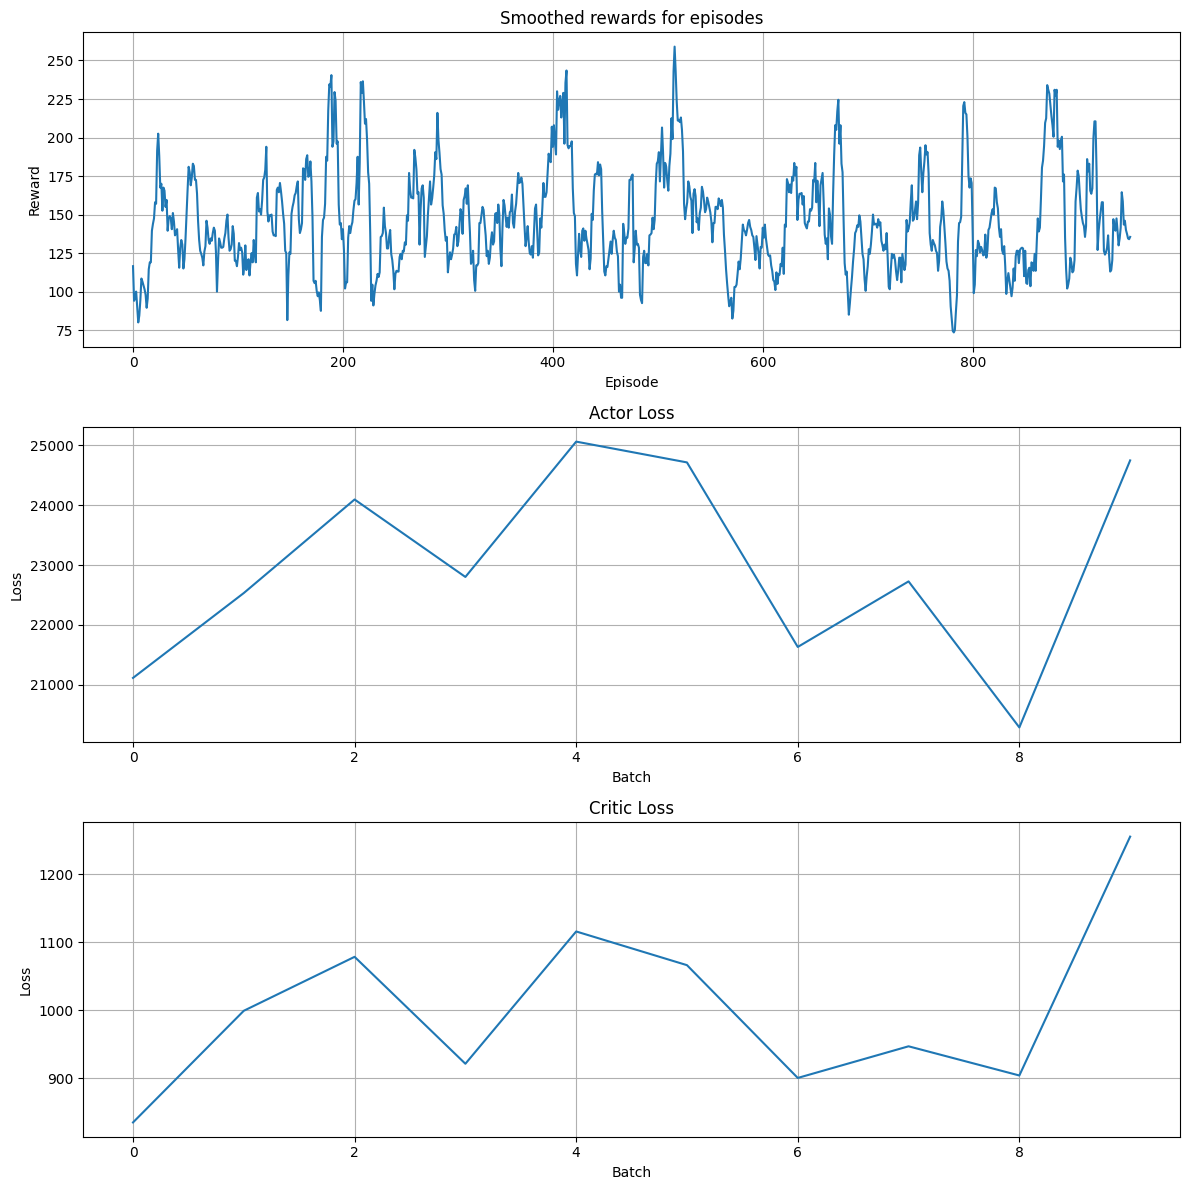

In [ ]:
agent.plot_training_results()

## Analyzing learning outcomes

In [ ]:
agent.analyze_results()

Average reward: 146.02 ± 94.91
Maximum reward: 650.00
Minimum reward: 0.00
Average reward over last 100 episodes: 154.80 ± 112.32
Reward coefficient of variation: 0.6500
Convergence rate: 0.1835 rewards/interval
Computational efficiency: 0.62 episodes/second
Total training time: 1547.10 seconds


## Ablation study ##

In [ ]:
agent.ablation_study()


Testing configuration: A2C
Average reward: 139.95

Testing configuration: A2C + V-trace
Average reward: 134.55

Testing configuration: A2C + Epsilon-greedy
Average reward: 165.00

Testing configuration: A2C + V-trace + Epsilon-greedy
Average reward: 156.35

Ablation study results:
A2C: 139.95
A2C + V-trace: 134.55
A2C + Epsilon-greedy: 165.00
A2C + V-trace + Epsilon-greedy: 156.35


## Video Recording

In [ ]:
# To display the video
def show_video_mediapy(video_path):
    """Displaying video with mediapy"""
    try:
        media.show_video(media.read_video(video_path), fps=30)
    except Exception as e:
        print(f"Error displaying video with mediapy: {e}")

In [ ]:
video_path = agent.record_best_episode_video("best_episode.mp4", fps=30)
if video_path:
    show_video_mediapy(video_path)

Recording best episode video...
Best episode: #476 with reward 650.0
Video recorded: 669 frames, size 160x210
Video saved as best_episode.mp4
Reward in recorded episode: 155.0


## Conclusion and Recommendations

The main components are:
1. Distributed A2C:
   - Utilizes multiple parallel workers to collect experiences
   - Global network to coordinate training
   - Asynchronous parameter updates
2. V-trace correction:
   - Off-policy correction to improve stability
   - Supports importans sampling
   - Dispersion control via weight trimming
3. Research strategies:
   - Epsilon-greedy: balance between exploitation and research
   - Boltzmann: softmax research with temperature
   - Standard: policy-based baseline strategy
4. Atari processing:
   - Frame preprocessing (grayscale, size 84x84)
   - Stacking 4 consecutive frames for temporal awareness
   - Converged networks for image processing
Advantages:
- High learning stability
- Good parallelization
- Support for off-policy learning via V-trace
- Flexible research strategies
Disadvantages:
- Requires more computational resources
- May be less sample-efficient compared to PPO

Recommendations:
1. Experiment with different exploration strategies (e.g., count-based research);
2. Customize the number of workers based on available computational resources;
3. Implement prioritized replay experiences for further improvements;
4. Adjust the V-TRACE pruning factor based on the characteristics of the environment;
5. Add adaptive learning rate adjustment;
6. Try other Atari environments to compare performance.